In [7]:
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F

from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')

import torch.optim as optim


# Data preprocessing utils : 
from utils.acdc_dataset import ACDC_Dataset, One_hot_Transform, load_dataset
from torchvision.transforms import Compose
from torchvision import transforms

from torch.utils.data import DataLoader


# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


# my defined model
from utils.vqVAE import VQVAE
# from uils.vqVAE_custom import VQVAE

from utils.training import *

## Preparing Dataset 

In [4]:
L = 128 # image size L=W
BATCH_SIZE = 16

In [5]:
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")



NameError: name 'os' is not defined

In [6]:
train_dataset = load_dataset(train_set_path)
test_dataset  = load_dataset(test_set_path)


input_transforms = Compose([
    transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
    One_hot_Transform(num_classes=4)
    ])


TrainDataset = ACDC_Dataset(data = train_dataset, transforms= input_transforms) 
TestDataset  = ACDC_Dataset(data = test_dataset, transforms= input_transforms)

TrainLoader  = DataLoader(TrainDataset, batch_size = BATCH_SIZE, shuffle = True)
TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = True)



NameError: name 'load_dataset' is not defined

## Prepairing the model

In [7]:
K =  256 # num_embeddings
D =  64 # embedding_dim
in_channels = 4 

In [8]:
ACDC_VQVAE = VQVAE(in_channels, D, K)


## Training the Model

In [9]:
# detect gpu ?

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


In [10]:
### Learning parameters

model = ACDC_VQVAE.to(device)

lr = 5e-4
epochs = 100
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

model_name = 'saved_models/vqvae_104_bestmodel.pth'

In [11]:
# visualisation batch, to track th eperformance of the model
vis_batch = next(iter(TestLoader)).to(device)

In [12]:
# def evaluate_model(model, val_loader):
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for batch in val_loader:
#             inputs = batch.float().to(device)
           
#             outputs, _, _, _ = model(inputs)
#             outputs_binary = F.softmax(outputs, dim=1)
            
#             # Loss and backward
#             loss = dice_loss_hard(inputs, outputs)
            
#             val_loss += loss.item()
    
#     avg_val_loss = val_loss / len(val_loader.dataset)
#     return avg_val_loss

In [13]:

model.train()
train_loss_values = []
codebook_loss_values = []

#track the evolution of reconstruction
recons_evolution = []

val_loss_values = []
best_val_loss = float('inf')

for epoch in range(epochs):

    train_loss = 0.0
    codebook_loss_epoch = 0.0

    with tqdm(enumerate(TrainLoader), unit="batch", total=len(TrainLoader)) as tepoch:
        for batch_idx, (inputs) in tepoch:
            inputs = inputs.float().to(device)  # Move data to the appropriate device (GPU/CPU)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass // args is a list containing : [output, input, vq_loss]
            output, inputs, codebook_loss, commit_loss = model(inputs)
            
            # Loss and backward
            loss = model.loss_function(output, inputs, codebook_loss, commit_loss)['loss']  # Use the loss function defined in the model
            loss.backward()
            optimizer.step()
            
            
            # Track running loss
            train_loss += loss.item()
            codebook_loss_epoch += codebook_loss.item()


            # tqdm bar displays the loss
            tepoch.set_postfix(loss=loss.item())

    epoch_loss = train_loss / len(TrainLoader.dataset)
    codebook_loss_epoch/= len(TrainLoader.dataset)

    train_loss_values.append(epoch_loss)
    codebook_loss_values.append(codebook_loss_epoch)

    # Validation after each epoch
    val_loss = evaluate_model(model, TestLoader, dice_loss, device)
    val_loss_values.append(val_loss)

    #track output precision progression every 10 epoch:
    if (epoch%5 == 0 and epoch<50):
        output, _, _, _ = model( vis_batch.float() )
        recons_evolution.append(output)


    #saving model if Loss values decreases
    if val_loss < best_val_loss :
        save_model(model_name, model, epoch, train_loss_values, val_loss_values, codebook_loss_values)

    print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(TrainLoader)))

print("Training complete.")

  0%|          | 0/119 [00:00<?, ?batch/s]

100%|██████████| 119/119 [00:07<00:00, 16.38batch/s, loss=1.11]  


Epoch 0: Train Loss: 222.4656


100%|██████████| 119/119 [00:05<00:00, 21.11batch/s, loss=8.96]   


Epoch 1: Train Loss: 1478.6733


100%|██████████| 119/119 [00:05<00:00, 21.38batch/s, loss=0.876]


Epoch 2: Train Loss: 25.6854


100%|██████████| 119/119 [00:05<00:00, 22.12batch/s, loss=1.83]


Epoch 3: Train Loss: 1.6100


100%|██████████| 119/119 [00:05<00:00, 21.81batch/s, loss=27.9]


Epoch 4: Train Loss: 10.0800


100%|██████████| 119/119 [00:06<00:00, 18.74batch/s, loss=22.8]


Epoch 5: Train Loss: 31.8239


100%|██████████| 119/119 [00:05<00:00, 20.73batch/s, loss=0.478]


Epoch 6: Train Loss: 3.7318


100%|██████████| 119/119 [00:05<00:00, 20.46batch/s, loss=0.715]


Epoch 7: Train Loss: 0.9999


100%|██████████| 119/119 [00:05<00:00, 19.90batch/s, loss=0.438]


Epoch 8: Train Loss: 0.3015


100%|██████████| 119/119 [00:05<00:00, 20.63batch/s, loss=0.148]


Epoch 9: Train Loss: 0.1686


100%|██████████| 119/119 [00:05<00:00, 20.02batch/s, loss=0.346]


Epoch 10: Train Loss: 0.2895


100%|██████████| 119/119 [00:06<00:00, 19.14batch/s, loss=0.118] 


Epoch 11: Train Loss: 0.1808


100%|██████████| 119/119 [00:05<00:00, 20.01batch/s, loss=0.0667]


Epoch 12: Train Loss: 0.1008


100%|██████████| 119/119 [00:05<00:00, 20.76batch/s, loss=0.0626]


Epoch 13: Train Loss: 0.0713


100%|██████████| 119/119 [00:05<00:00, 21.25batch/s, loss=0.0614]


Epoch 14: Train Loss: 0.0630


100%|██████████| 119/119 [00:05<00:00, 21.70batch/s, loss=0.0579]


Epoch 15: Train Loss: 0.0611


100%|██████████| 119/119 [00:05<00:00, 22.05batch/s, loss=0.0563]


Epoch 16: Train Loss: 0.0595


100%|██████████| 119/119 [00:05<00:00, 21.13batch/s, loss=0.0509]


Epoch 17: Train Loss: 0.0578


100%|██████████| 119/119 [00:05<00:00, 21.41batch/s, loss=0.0554]


Epoch 18: Train Loss: 0.0550


100%|██████████| 119/119 [00:05<00:00, 20.61batch/s, loss=0.0498]


Epoch 19: Train Loss: 0.0511


100%|██████████| 119/119 [00:05<00:00, 20.32batch/s, loss=0.0519]


Epoch 20: Train Loss: 0.0491


100%|██████████| 119/119 [00:05<00:00, 20.69batch/s, loss=0.0511]


Epoch 21: Train Loss: 0.0477


100%|██████████| 119/119 [00:05<00:00, 20.23batch/s, loss=0.0484]


Epoch 22: Train Loss: 0.0464


100%|██████████| 119/119 [00:05<00:00, 20.93batch/s, loss=0.0518]


Epoch 23: Train Loss: 0.0456


100%|██████████| 119/119 [00:05<00:00, 20.52batch/s, loss=0.0463]


Epoch 24: Train Loss: 0.0443


100%|██████████| 119/119 [00:06<00:00, 18.98batch/s, loss=0.0441]


Epoch 25: Train Loss: 0.0433


100%|██████████| 119/119 [00:06<00:00, 19.38batch/s, loss=0.0376]


Epoch 26: Train Loss: 0.0426


100%|██████████| 119/119 [00:05<00:00, 20.21batch/s, loss=0.0417]


Epoch 27: Train Loss: 0.0415


100%|██████████| 119/119 [00:06<00:00, 19.08batch/s, loss=0.0391]


Epoch 28: Train Loss: 0.0405


100%|██████████| 119/119 [00:05<00:00, 20.93batch/s, loss=0.0379]


Epoch 29: Train Loss: 0.0394


100%|██████████| 119/119 [00:05<00:00, 21.23batch/s, loss=0.0415]


Epoch 30: Train Loss: 0.0389


100%|██████████| 119/119 [00:06<00:00, 19.52batch/s, loss=0.0398]


Epoch 31: Train Loss: 0.0381


100%|██████████| 119/119 [00:05<00:00, 20.46batch/s, loss=0.0373]


Epoch 32: Train Loss: 0.0372


100%|██████████| 119/119 [00:05<00:00, 21.04batch/s, loss=0.0386]


Epoch 33: Train Loss: 0.0366


100%|██████████| 119/119 [00:05<00:00, 21.10batch/s, loss=0.0404]


Epoch 34: Train Loss: 0.0362


100%|██████████| 119/119 [00:05<00:00, 21.47batch/s, loss=0.037] 


Epoch 35: Train Loss: 0.0355


100%|██████████| 119/119 [00:05<00:00, 21.55batch/s, loss=0.0362]


Epoch 36: Train Loss: 0.0351


100%|██████████| 119/119 [00:05<00:00, 21.79batch/s, loss=0.0333]


Epoch 37: Train Loss: 0.0347


100%|██████████| 119/119 [00:05<00:00, 20.28batch/s, loss=0.0341]


Epoch 38: Train Loss: 0.0343


100%|██████████| 119/119 [00:05<00:00, 21.16batch/s, loss=0.0364]


Epoch 39: Train Loss: 0.0339


100%|██████████| 119/119 [00:05<00:00, 20.74batch/s, loss=0.0335]


Epoch 40: Train Loss: 0.0338


100%|██████████| 119/119 [00:05<00:00, 21.58batch/s, loss=0.031] 


Epoch 41: Train Loss: 0.0337


100%|██████████| 119/119 [00:05<00:00, 20.68batch/s, loss=0.0315]


Epoch 42: Train Loss: 0.0334


100%|██████████| 119/119 [00:05<00:00, 21.44batch/s, loss=0.0329]


Epoch 43: Train Loss: 0.0327


100%|██████████| 119/119 [00:06<00:00, 19.74batch/s, loss=0.0271]


Epoch 44: Train Loss: 0.0324


100%|██████████| 119/119 [00:05<00:00, 21.47batch/s, loss=0.0344]


Epoch 45: Train Loss: 0.0320


100%|██████████| 119/119 [00:05<00:00, 22.13batch/s, loss=0.03]  


Epoch 46: Train Loss: 0.0316


100%|██████████| 119/119 [00:05<00:00, 22.48batch/s, loss=0.0336]


Epoch 47: Train Loss: 0.0312


100%|██████████| 119/119 [00:05<00:00, 21.14batch/s, loss=0.0305]


Epoch 48: Train Loss: 0.0308


100%|██████████| 119/119 [00:05<00:00, 21.85batch/s, loss=0.0262]


Epoch 49: Train Loss: 0.0307


100%|██████████| 119/119 [00:05<00:00, 20.86batch/s, loss=0.0243]


Epoch 50: Train Loss: 0.0301


100%|██████████| 119/119 [00:05<00:00, 19.85batch/s, loss=0.0322]


Epoch 51: Train Loss: 0.0298


100%|██████████| 119/119 [00:06<00:00, 19.83batch/s, loss=0.0271]


Epoch 52: Train Loss: 0.0295


100%|██████████| 119/119 [00:06<00:00, 19.37batch/s, loss=0.0277]


Epoch 53: Train Loss: 0.0294


100%|██████████| 119/119 [00:05<00:00, 20.29batch/s, loss=0.0304]


Epoch 54: Train Loss: 0.0290


100%|██████████| 119/119 [00:05<00:00, 20.08batch/s, loss=0.0265]


Epoch 55: Train Loss: 0.0287


100%|██████████| 119/119 [00:05<00:00, 20.35batch/s, loss=0.0253]


Epoch 56: Train Loss: 0.0283


100%|██████████| 119/119 [00:05<00:00, 20.06batch/s, loss=0.0269]


Epoch 57: Train Loss: 0.0279


100%|██████████| 119/119 [00:05<00:00, 20.35batch/s, loss=0.0252]


Epoch 58: Train Loss: 0.0277


100%|██████████| 119/119 [00:05<00:00, 20.39batch/s, loss=0.0215]


Epoch 59: Train Loss: 0.0274


100%|██████████| 119/119 [00:05<00:00, 20.75batch/s, loss=0.027] 


Epoch 60: Train Loss: 0.0271


100%|██████████| 119/119 [00:05<00:00, 20.29batch/s, loss=0.0256]


Epoch 61: Train Loss: 0.0269


100%|██████████| 119/119 [00:05<00:00, 20.20batch/s, loss=0.0225]


Epoch 62: Train Loss: 0.0264


100%|██████████| 119/119 [00:05<00:00, 20.08batch/s, loss=0.0249]


Epoch 63: Train Loss: 0.0263


100%|██████████| 119/119 [00:05<00:00, 20.12batch/s, loss=0.0276]


Epoch 64: Train Loss: 0.0258


100%|██████████| 119/119 [00:05<00:00, 20.42batch/s, loss=0.0254]


Epoch 65: Train Loss: 0.0253


100%|██████████| 119/119 [00:05<00:00, 20.36batch/s, loss=0.028] 


Epoch 66: Train Loss: 0.0249


100%|██████████| 119/119 [00:06<00:00, 19.07batch/s, loss=0.0228]


Epoch 67: Train Loss: 0.0247


100%|██████████| 119/119 [00:05<00:00, 20.64batch/s, loss=0.0211]


Epoch 68: Train Loss: 0.0242


100%|██████████| 119/119 [00:05<00:00, 21.31batch/s, loss=0.0233]


Epoch 69: Train Loss: 0.0239


100%|██████████| 119/119 [00:05<00:00, 20.53batch/s, loss=0.0251]


Epoch 70: Train Loss: 0.0234


100%|██████████| 119/119 [00:05<00:00, 20.06batch/s, loss=0.0225]


Epoch 71: Train Loss: 0.0231


100%|██████████| 119/119 [00:05<00:00, 19.91batch/s, loss=0.0201]


Epoch 72: Train Loss: 0.0227


100%|██████████| 119/119 [00:06<00:00, 19.79batch/s, loss=0.022] 


Epoch 73: Train Loss: 0.0222


100%|██████████| 119/119 [00:06<00:00, 19.47batch/s, loss=0.022] 


Epoch 74: Train Loss: 0.0221


100%|██████████| 119/119 [00:05<00:00, 20.33batch/s, loss=0.0157]


Epoch 75: Train Loss: 0.0218


100%|██████████| 119/119 [00:05<00:00, 20.18batch/s, loss=0.0242]


Epoch 76: Train Loss: 0.0213


100%|██████████| 119/119 [00:05<00:00, 21.30batch/s, loss=0.021] 


Epoch 77: Train Loss: 0.0212


100%|██████████| 119/119 [00:05<00:00, 20.06batch/s, loss=0.0232]


Epoch 78: Train Loss: 0.0208


100%|██████████| 119/119 [00:05<00:00, 20.02batch/s, loss=0.0229]


Epoch 79: Train Loss: 0.0205


100%|██████████| 119/119 [00:05<00:00, 20.65batch/s, loss=0.0188]


Epoch 80: Train Loss: 0.0203


100%|██████████| 119/119 [00:05<00:00, 19.98batch/s, loss=0.0229]


Epoch 81: Train Loss: 0.0202


100%|██████████| 119/119 [00:06<00:00, 19.82batch/s, loss=0.0211]


Epoch 82: Train Loss: 0.0200


100%|██████████| 119/119 [00:05<00:00, 20.16batch/s, loss=0.0204]


Epoch 83: Train Loss: 0.0198


100%|██████████| 119/119 [00:05<00:00, 20.53batch/s, loss=0.0187]


Epoch 84: Train Loss: 0.0195


100%|██████████| 119/119 [00:05<00:00, 20.38batch/s, loss=0.0152]


Epoch 85: Train Loss: 0.0192


100%|██████████| 119/119 [00:06<00:00, 19.67batch/s, loss=0.0153]


Epoch 86: Train Loss: 0.0189


100%|██████████| 119/119 [00:05<00:00, 20.34batch/s, loss=0.0206]


Epoch 87: Train Loss: 0.0187


100%|██████████| 119/119 [00:06<00:00, 19.62batch/s, loss=0.0164]


Epoch 88: Train Loss: 0.0187


100%|██████████| 119/119 [00:06<00:00, 19.81batch/s, loss=0.018] 


Epoch 89: Train Loss: 0.0182


100%|██████████| 119/119 [00:05<00:00, 19.84batch/s, loss=0.0166]


Epoch 90: Train Loss: 0.0178


100%|██████████| 119/119 [00:05<00:00, 20.16batch/s, loss=0.0182]


Epoch 91: Train Loss: 0.0176


100%|██████████| 119/119 [00:05<00:00, 20.35batch/s, loss=0.0185]


Epoch 92: Train Loss: 0.0176


100%|██████████| 119/119 [00:06<00:00, 19.46batch/s, loss=0.0171]


Epoch 93: Train Loss: 0.0171


100%|██████████| 119/119 [00:05<00:00, 20.59batch/s, loss=0.0149]


Epoch 94: Train Loss: 0.0173


100%|██████████| 119/119 [00:05<00:00, 20.28batch/s, loss=0.015] 


Epoch 95: Train Loss: 0.0169


100%|██████████| 119/119 [00:05<00:00, 19.94batch/s, loss=0.0155]


Epoch 96: Train Loss: 0.0164


100%|██████████| 119/119 [00:06<00:00, 19.76batch/s, loss=0.0163]


Epoch 97: Train Loss: 0.0167


100%|██████████| 119/119 [00:06<00:00, 19.69batch/s, loss=0.0165]


Epoch 98: Train Loss: 0.0166


100%|██████████| 119/119 [00:06<00:00, 19.52batch/s, loss=0.0167]


Epoch 99: Train Loss: 0.0162
Training complete.


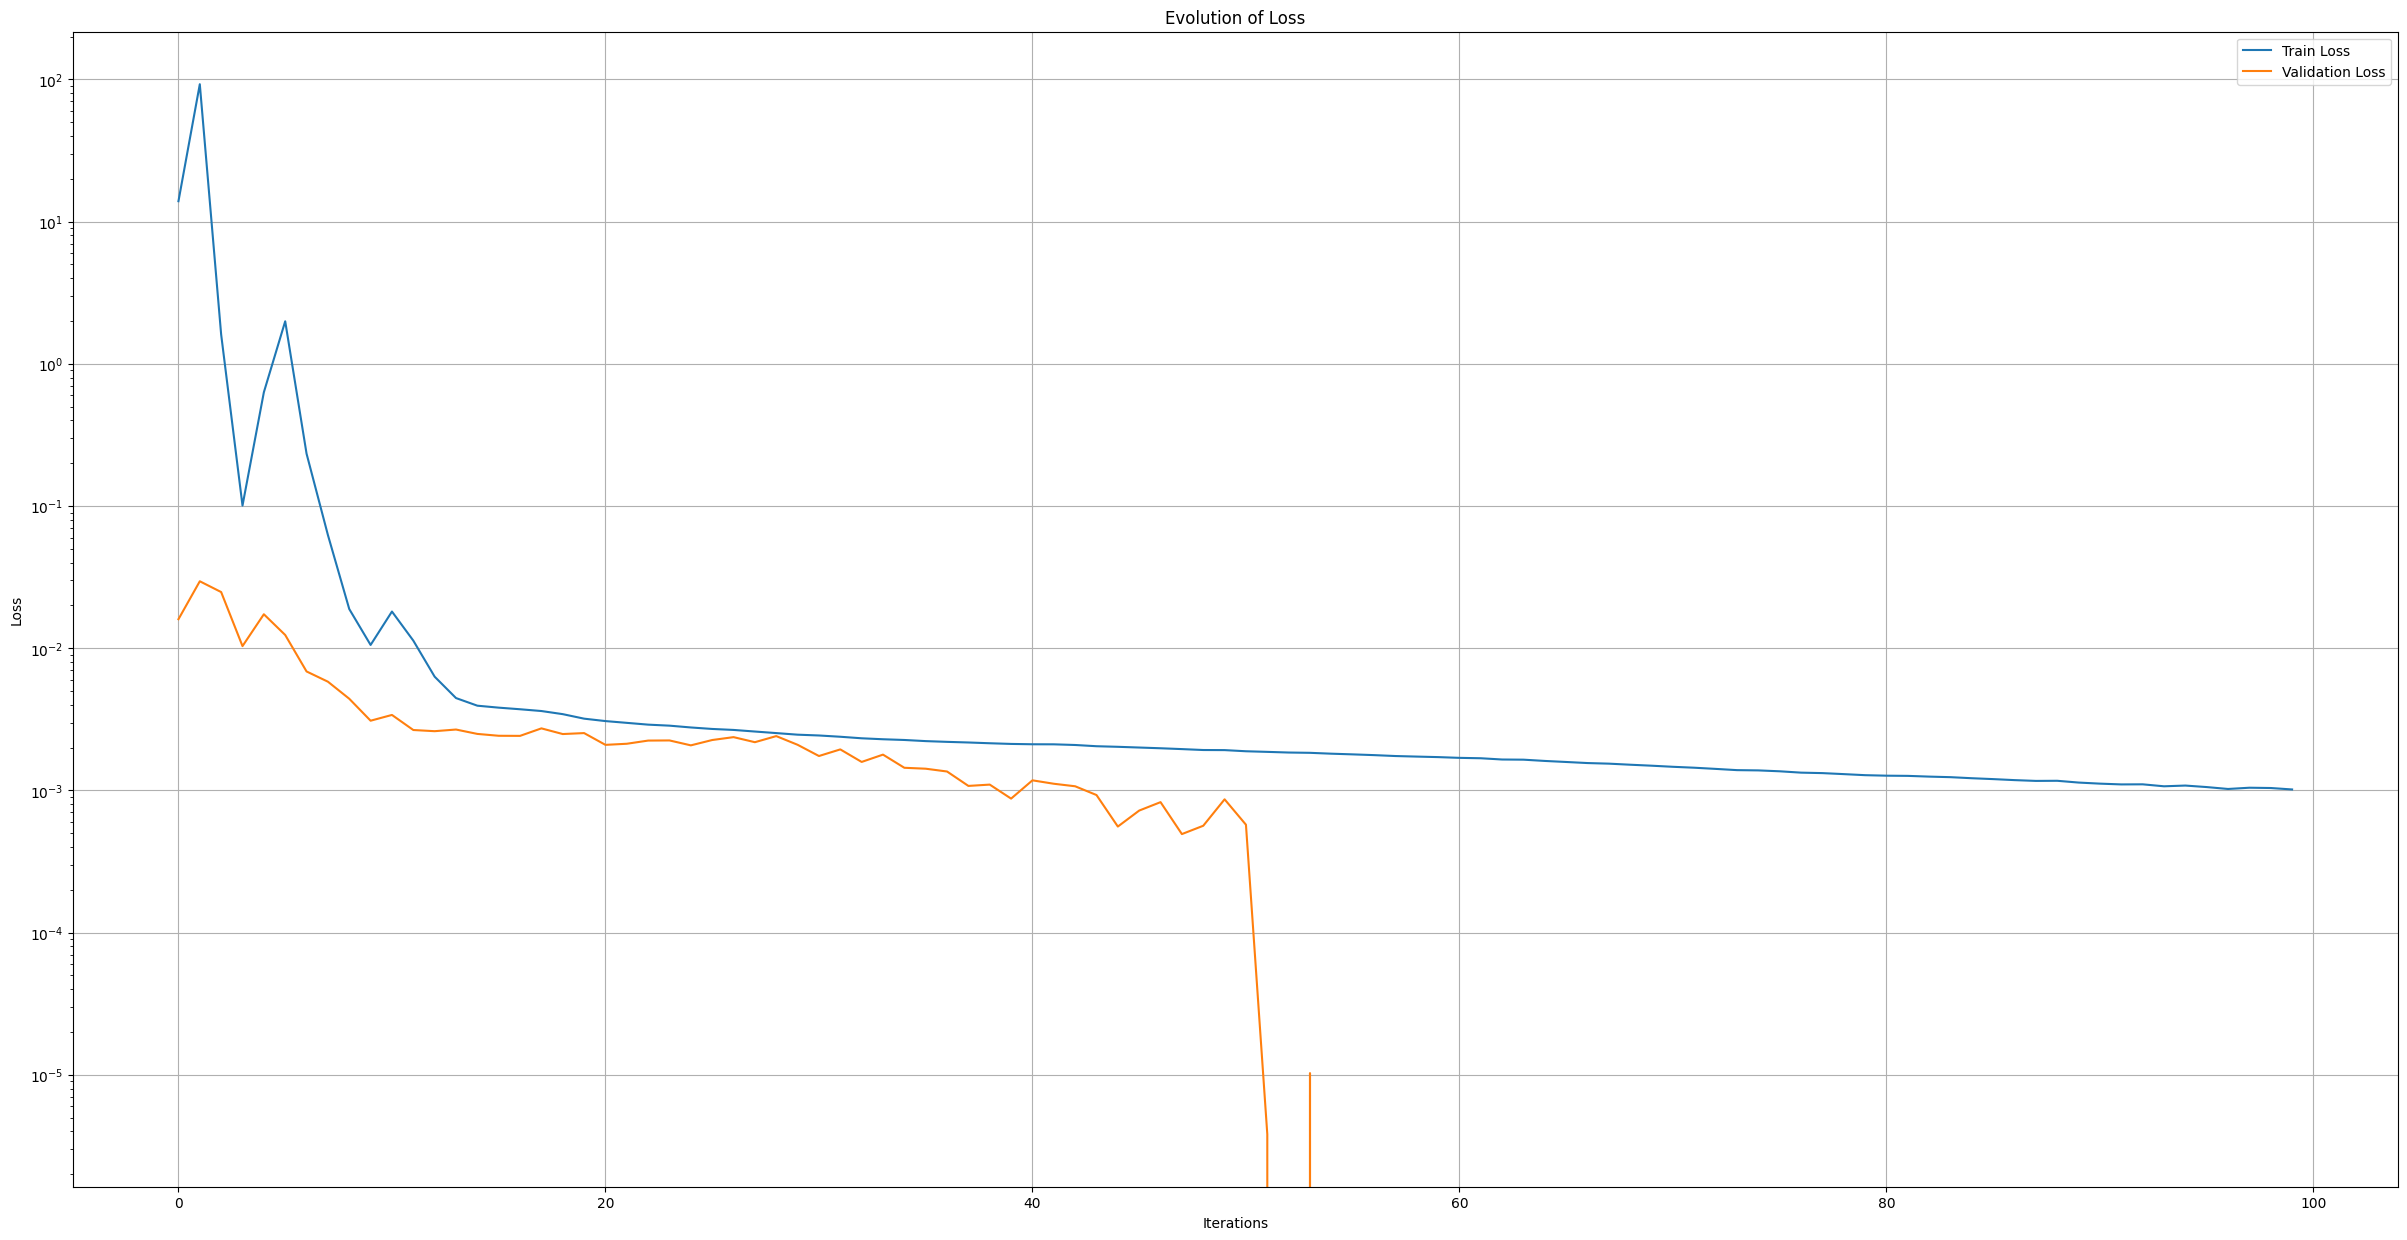

In [14]:
# Plot the training and validation losses
plot_train_val_loss(train_loss_values, val_loss_values)

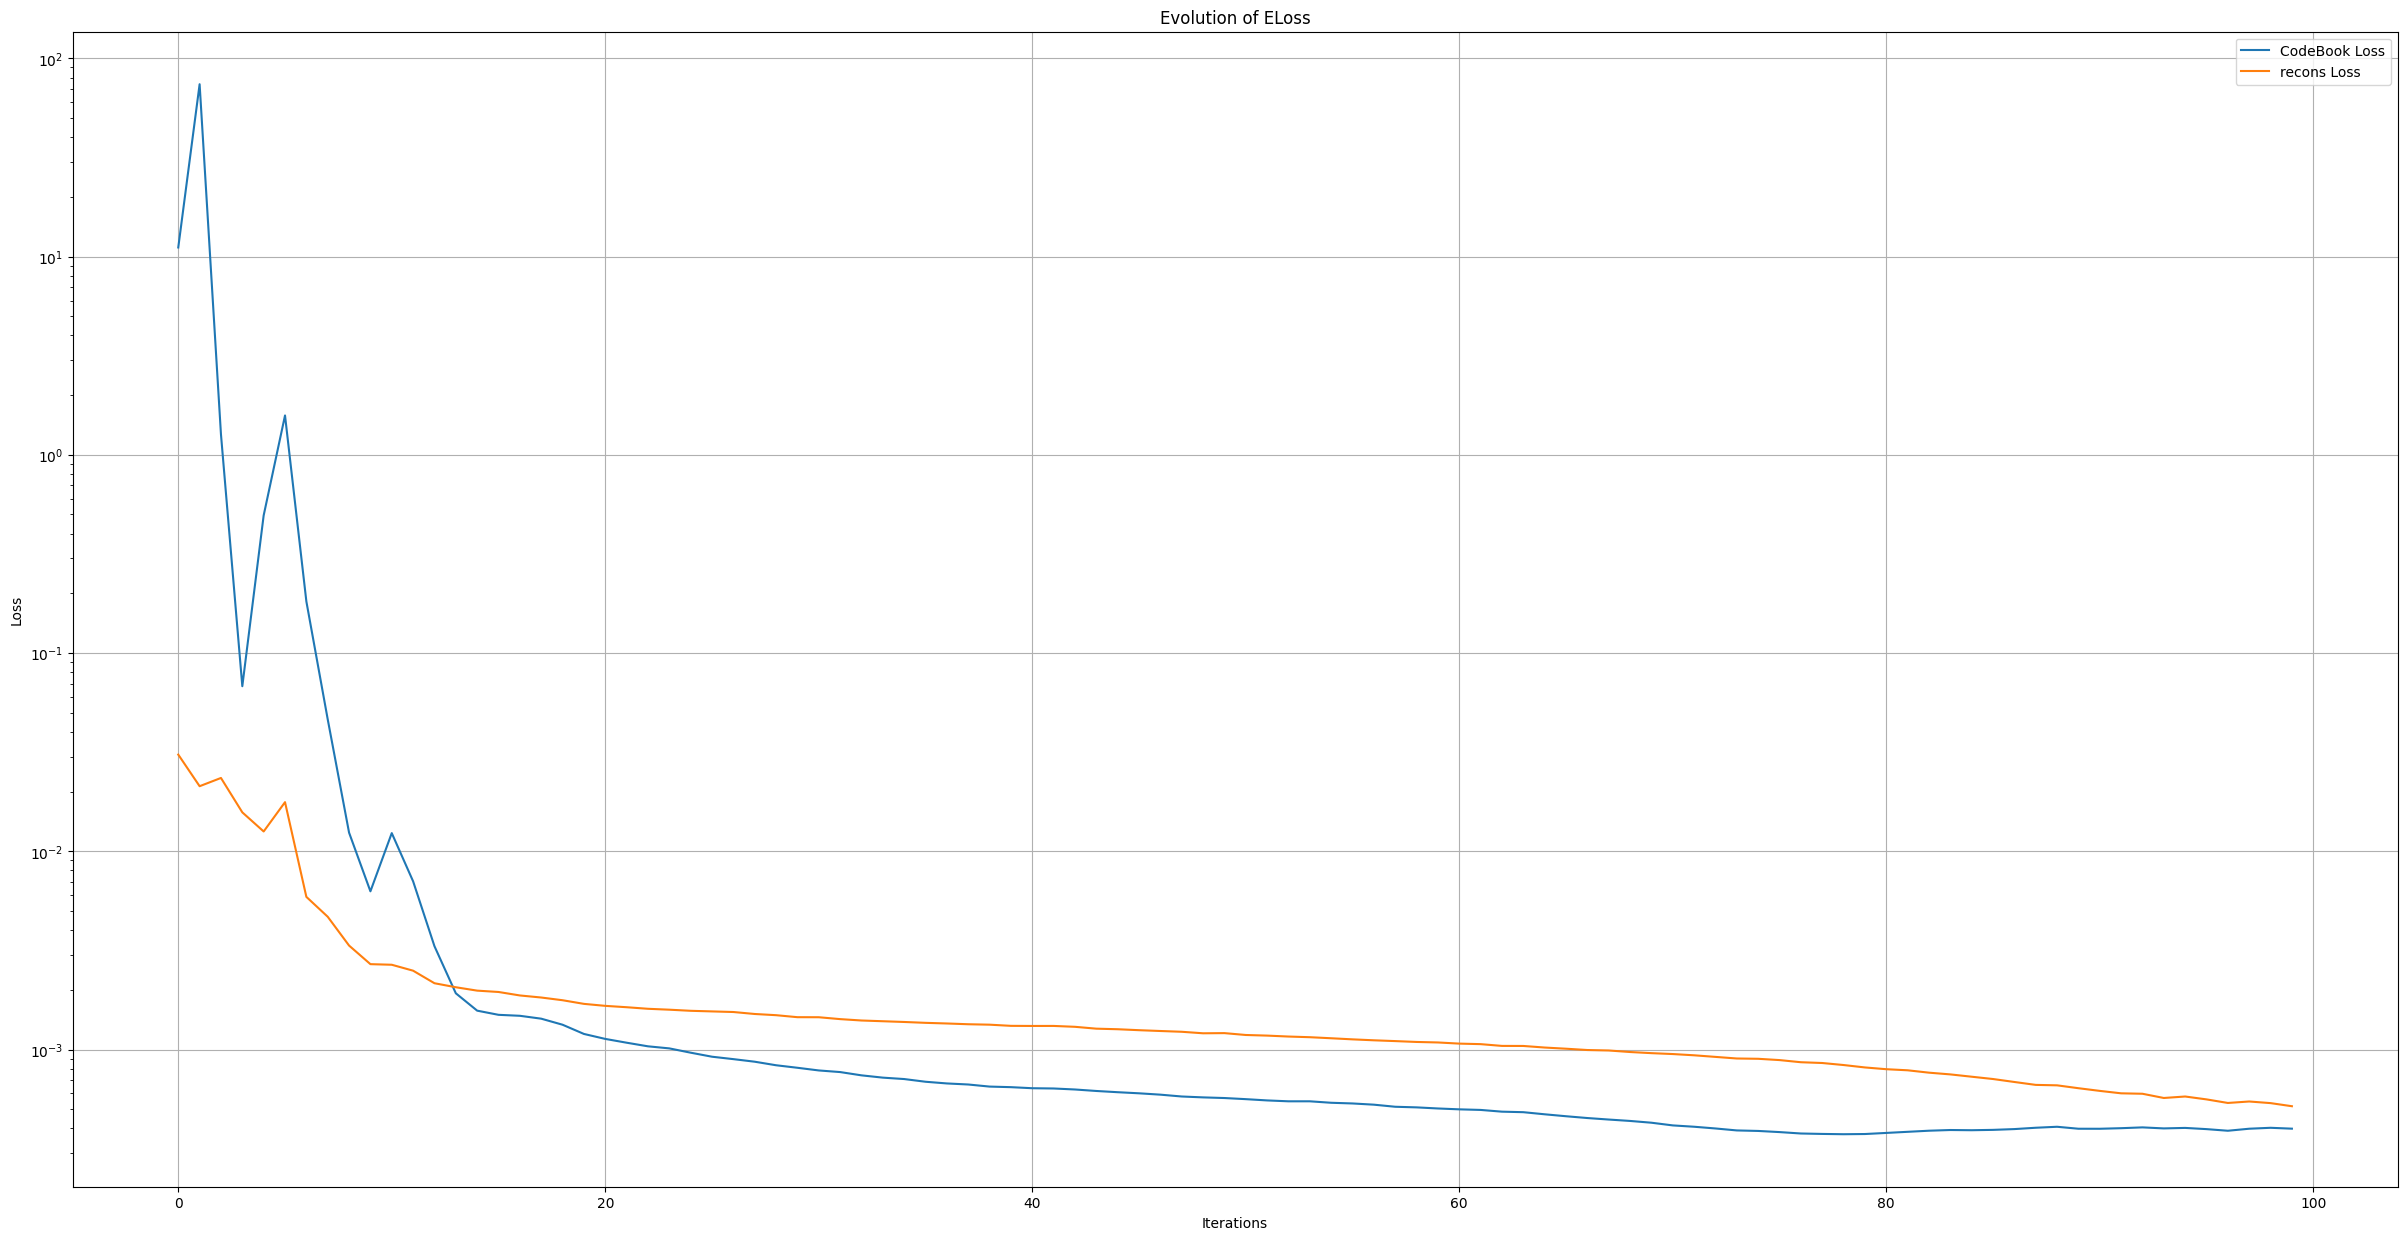

In [18]:


# plot_rc_loss(train_loss_values, codebook_loss_values, beta=0.25)

recons_loss_values = np.array(train_loss_values) - ( (1+0.25)*np.array(codebook_loss_values))
# Plot the training and validation losses
plt.figure(figsize=(30, 15))
# plt.plot(train_loss_values, label='Train Loss')
# plt.plot(val_loss_values, label='Validation Loss')
plt.plot(codebook_loss_values, label = "CodeBook Loss")
# plt.plot(commit_loss_values, label = "Committement Loss")
plt.plot(recons_loss_values, label = "recons Loss")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Evolution of ELoss')
plt.legend()
plt.grid()
plt.show()


# Test ...

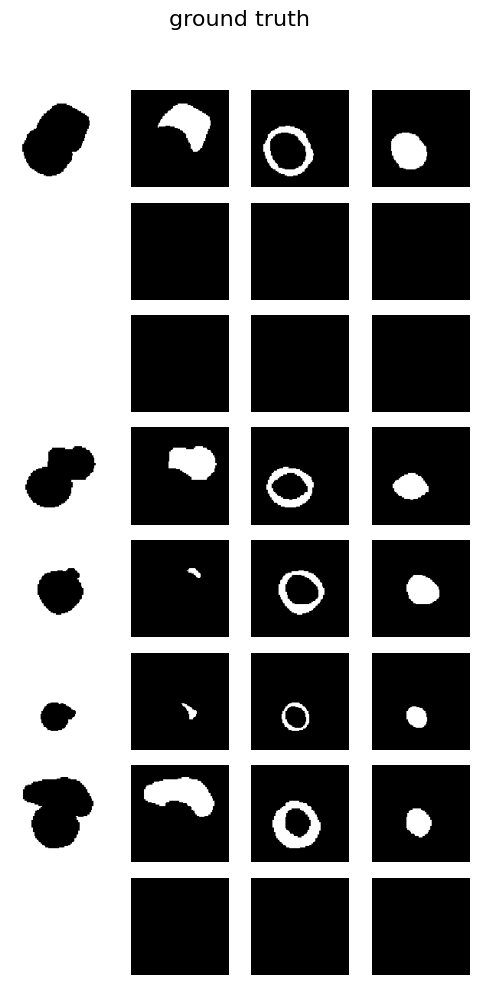

In [19]:
visualize_batch(vis_batch.detach().cpu(), title = "ground truth")

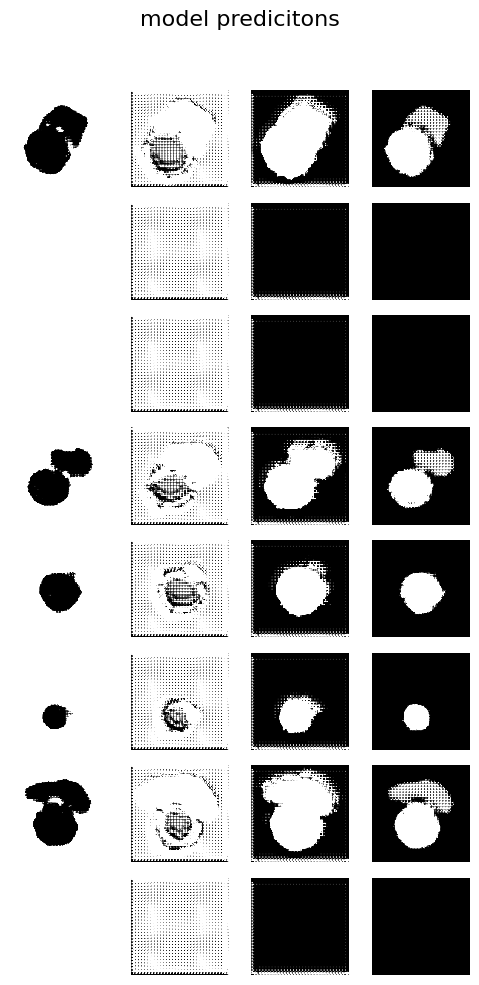

In [22]:
batch_hat = reconstruct_logits(vis_batch, model)

visualize_batch( batch_hat.detach().cpu(), title = "model predicitons")

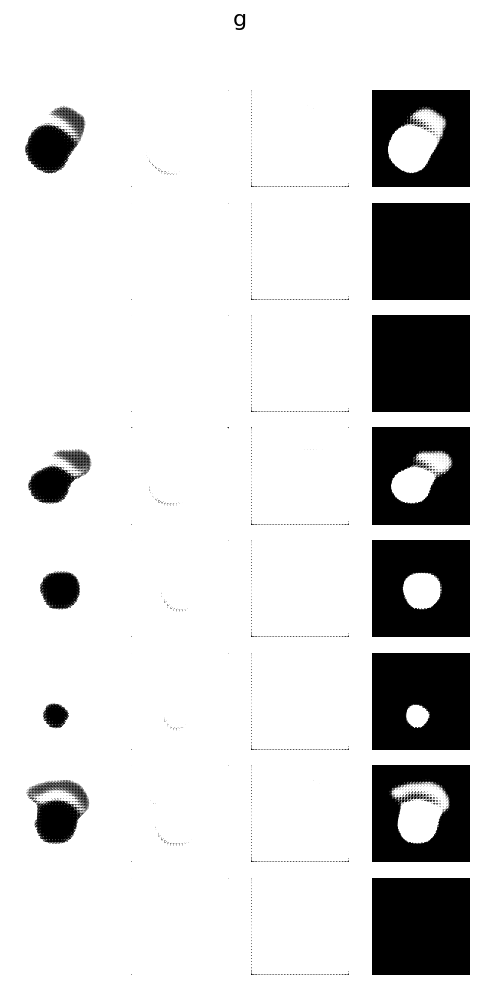

In [21]:
visualize_batch(recons_evolution[1].detach().cpu(), title = "g")